In [1]:
from datetime import timedelta

import pandas as pd
import sklearn.metrics as metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance

In [2]:
# Loading our dataset
orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
products_translations = pd.read_csv('data/product_category_name_translation.csv')
products = pd.read_csv("data/olist_products_dataset.csv")
orderreviews_data = pd.read_csv('data/olist_order_reviews_dataset.csv')
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
payments = pd.read_csv('data/olist_order_payments_dataset.csv')

In [3]:
# converting dates to pandas datetime format for easy date functions
orders['order_delivered_carrier_date'] = orders[['order_delivered_carrier_date']] \
    .apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y-%m-%d %H:%M:%S')) \
    .apply(lambda x: x.dt.date) \
    .astype('datetime64')

In [4]:
# joining necessary data and feature engineering new columns
orders = orders.dropna(subset=['order_delivered_carrier_date'])
recent_date = orders['order_delivered_carrier_date'].max() + timedelta(days=1)
merged_data = orders.merge(payments, how='inner', on=['order_id'])
rfm_df = merged_data.groupby('customer_id').agg(
    recency=('order_delivered_carrier_date', lambda x: (recent_date - x.max()).days),
    frequency=('payment_sequential', 'count'),
    monetary=('payment_value', 'sum'))
rfm_df.head()

,recency,frequency,monetary
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,299,1,114.74
000161a058600d5901f007fab4c27140,420,1,67.41
0001fd6190edaaf884bcaf3d49edf079,560,1,195.42
0002414f95344307404f0ace7a26f1d5,389,1,179.35
000379cdec625522490c315e70c7a9fb,161,1,107.01


In [5]:
# Adding RFM scores
rfm_df["recency_score"] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df["frequency_score"] = pd.qcut(rfm_df['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_df["monetary_score"] = pd.qcut(rfm_df['monetary'], 5, labels=[1, 2, 3, 4, 5])

In [6]:
rfm_df['rfm_score'] = rfm_df.recency_score.astype(str) + rfm_df.frequency_score.astype(
    str) + rfm_df.monetary_score.astype(str)
rfm_df

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
customer_id,,,,,,,
00012a2ce6f8dcda20d059ce98491703,299,1,114.74,2,1,3,213
000161a058600d5901f007fab4c27140,420,1,67.41,1,1,2,112
0001fd6190edaaf884bcaf3d49edf079,560,1,195.42,1,1,4,114
0002414f95344307404f0ace7a26f1d5,389,1,179.35,2,1,4,214
000379cdec625522490c315e70c7a9fb,161,1,107.01,4,1,3,413
...,...,...,...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,179,1,91.91,4,5,3,453
fffecc9f79fd8c764f843e9951b11341,165,3,81.36,4,5,2,452
fffeda5b6d849fbd39689bb92087f431,110,1,63.13,4,5,2,452


In [7]:
# assigning RFM mappings
rfm_score_mappings = {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

rfm_df['segment'] = rfm_df['recency_score'].astype(str) + rfm_df['frequency_score'].astype(str) + rfm_df[
    'monetary_score'].astype(str)
rfm_df['segment'] = rfm_df['segment'].replace(rfm_score_mappings, regex=True)
rfm_df.head()
# rfm_df = rfm_df.dropna()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,segment
customer_id,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,299,1,114.74,2,1,3,213,About To Sleep
000161a058600d5901f007fab4c27140,420,1,67.41,1,1,2,112,Lost customers
0001fd6190edaaf884bcaf3d49edf079,560,1,195.42,1,1,4,114,Cannot Lose Them
0002414f95344307404f0ace7a26f1d5,389,1,179.35,2,1,4,214,Cannot Lose Them
000379cdec625522490c315e70c7a9fb,161,1,107.01,4,1,3,413,Promising


In [8]:
rfm_df1 = rfm_df[['recency', 'frequency', 'monetary', 'rfm_score']]
rfm_df1

,recency,frequency,monetary,rfm_score
customer_id,,,,
00012a2ce6f8dcda20d059ce98491703,299,1,114.74,213
000161a058600d5901f007fab4c27140,420,1,67.41,112
0001fd6190edaaf884bcaf3d49edf079,560,1,195.42,114
0002414f95344307404f0ace7a26f1d5,389,1,179.35,214
000379cdec625522490c315e70c7a9fb,161,1,107.01,413
...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,179,1,91.91,453
fffecc9f79fd8c764f843e9951b11341,165,3,81.36,452
fffeda5b6d849fbd39689bb92087f431,110,1,63.13,452


In [9]:
# joining our data into one single dataframe
df = rfm_df1.merge(orders, how='inner', on=['customer_id'])
df = df.merge(customers, how="inner", on=["customer_id"])
df = df.merge(order_items, how="inner", on=["order_id"])
df = df.merge(payments, how="inner", on=["order_id"])
df = df.merge(orderreviews_data, how="inner", on=["order_id"])
df = df.merge(products, how="inner", on=["product_id"])
df = df.merge(products_translations, how="inner", on=["product_category_name"])
df = df.dropna()
df.head()

,customer_id,recency,frequency,monetary,rfm_score,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
3,2b685398c61b72f24fce6c289aa1d810,77,1,98.29,513,d266e87fb98640ecbbe91425c76e72f3,delivered,2018-06-26 18:03:15,2018-06-26 18:18:44,2018-06-27,...,2018-07-24 14:20:39,brinquedos,55.0,889.0,1.0,4267.0,46.0,39.0,22.0,toys
160,f55791b5a2b3a4f027ad2523dbdf7b2f,82,1,125.02,553,991822bb734dbc3bbda5554397c3d957,delivered,2018-06-21 22:14:25,2018-06-21 22:38:24,2018-06-22,...,2018-07-03 11:11:31,brinquedos,45.0,404.0,5.0,3850.0,52.0,7.0,55.0,toys
229,e1d1dee29c972491405875c9e08cc86b,100,1,312.95,555,6da0685c82e8535a05cf6b4e4eabc52e,delivered,2018-06-02 21:58:31,2018-06-02 22:11:42,2018-06-04,...,2018-06-07 16:26:22,brinquedos,48.0,819.0,4.0,1538.0,25.0,36.0,31.0,toys
246,012e0c27bbc549e7c249ee9042d58f7b,126,1,232.88,415,c921b31250ffb9719326413202688113,delivered,2018-05-07 13:37:30,2018-05-07 15:33:06,2018-05-09,...,2018-05-24 01:13:34,brinquedos,47.0,1100.0,6.0,2025.0,50.0,27.0,27.0,toys
319,ee80fd5b86cbb55e2b93eabf04ede7a4,142,1,220.02,455,8f83b7fcba464b677274cb8fcf22eef8,delivered,2018-04-21 14:30:01,2018-04-24 19:19:39,2018-04-23,...,2018-05-03 13:37:59,brinquedos,48.0,1006.0,2.0,2300.0,61.0,26.0,26.0,toys


In [10]:
# selecting the best features using chi-square test performed in the earlier notebook (Customer Segmentation DBSCAN.ipynb)
df_train = df[
    ["customer_zip_code_prefix", "product_description_lenght", "product_weight_g", "recency", "frequency", "monetary"]]
df_train2 = df_train.copy()
df_train.head()

,customer_zip_code_prefix,product_description_lenght,product_weight_g,recency,frequency,monetary
3,32185,889.0,4267.0,77,1,98.29
160,85770,404.0,3850.0,82,1,125.02
229,22020,819.0,1538.0,100,1,312.95
246,41750,1100.0,2025.0,126,1,232.88
319,13178,1006.0,2300.0,142,1,220.02


In [11]:
# sacling our data to deal with outliers
scaler = MinMaxScaler()
df_train1 = df_train.copy()

df_train1[['customer_zip_code_prefix', 'product_description_lenght', 'product_weight_g', 'recency',
           'monetary']] = scaler.fit_transform(
    df_train1[['customer_zip_code_prefix', 'product_description_lenght', 'product_weight_g', 'recency', 'monetary']])

df_train2 = df_train1.copy()


In [12]:
df_train1.head()

,customer_zip_code_prefix,product_description_lenght,product_weight_g,recency,frequency,monetary
3,0.315043,0.222306,0.142233,0.141079,1,0.011624
160,0.856431,0.100477,0.128333,0.151452,1,0.015305
229,0.212342,0.204722,0.051267,0.188797,1,0.041187
246,0.411682,0.275308,0.067500,0.242739,1,0.030160
319,0.123008,0.251696,0.076667,0.275934,1,0.028389


### K-Means

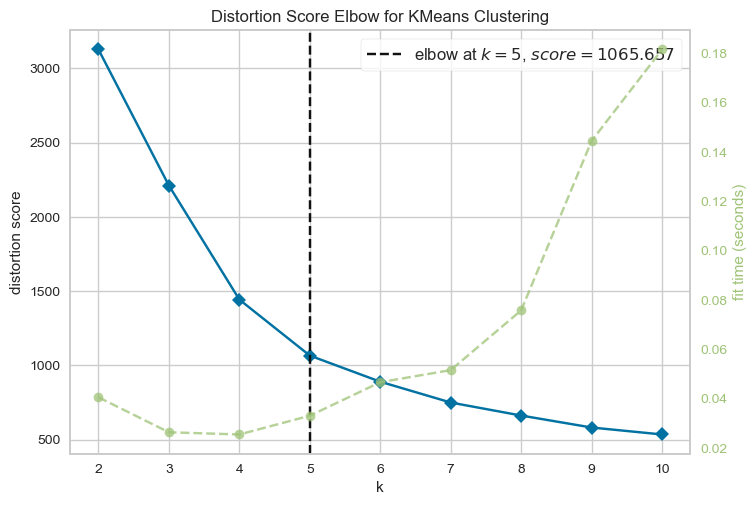

In [13]:
# using the elbow method to determine the number of cluster required
elbow_viz = KElbowVisualizer(KMeans(), K=(4, 12), metrics=["silhouette"])

elbow_viz.fit(df_train1)
elbow_viz.finalize()

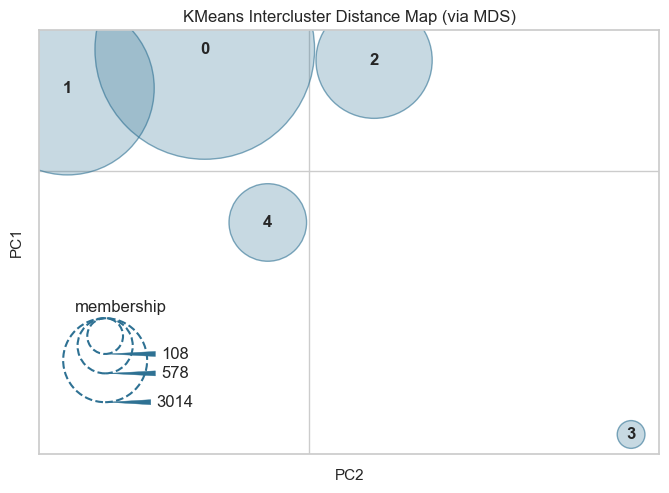

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [15]:
# looking at the interdistance cluster to check how our clusters are seperated for the elbow value.
inter_cluster_distance_viz = InterclusterDistance(KMeans(5))
inter_cluster_distance_viz.fit(df_train1)
inter_cluster_distance_viz.show()

In [16]:
# executing kmeans based on the number of clusters we got from the elbow method
k_means = KMeans(5)
k_means.fit(df_train1)

# saving the labels in our dataframe
kmeans_labels = k_means.labels_
df_train1["kmeans_label"] = kmeans_labels

In [17]:
# labels = k_means.labels_
print("Silhouette Score: %0.3f" % metrics.silhouette_score(df_train1, kmeans_labels))
print("Calinski-Harabasz Score: %0.3f" % metrics.calinski_harabasz_score(df_train1, kmeans_labels))

Silhouette Score: 0.727
Calinski-Harabasz Score: 27398.637


In [18]:
# getting our mean data for our clusters.
k_means_metrics = df_train1.groupby("kmeans_label").mean().reset_index()
k_means_metrics

,kmeans_label,customer_zip_code_prefix,product_description_lenght,product_weight_g,recency,frequency,monetary
0,0,0.167739,0.198741,0.069597,0.156248,1.000000,0.023913
1,1,0.761191,0.215639,0.070141,0.162668,1.000000,0.032391
2,2,0.333691,0.208598,0.077066,0.162389,2.197232,0.028882
3,3,0.828698,0.084150,0.060000,0.253112,12.000000,0.007723
4,4,0.317672,0.230193,0.133539,0.189680,5.166667,0.032683


In [19]:
# inserting our assigned clusters into the main dataframe
df_train.insert(df_train.shape[1], 'rfm_score', list(df['rfm_score']))
df_train.insert(df_train.shape[1], 'segment', df_train['rfm_score'].replace(rfm_score_mappings, regex=True))
df_train.insert(df_train.shape[1], 'kmeans_label', kmeans_labels)

df_train

,customer_zip_code_prefix,product_description_lenght,product_weight_g,recency,frequency,monetary,rfm_score,segment,kmeans_label
3,32185,889.0,4267.0,77,1,98.29,513,Promising,0
160,85770,404.0,3850.0,82,1,125.02,553,Potential Loyalist,1
229,22020,819.0,1538.0,100,1,312.95,555,Champions,0
246,41750,1100.0,2025.0,126,1,232.88,415,Promising,0
319,13178,1006.0,2300.0,142,1,220.02,455,Champions,0
...,...,...,...,...,...,...,...,...,...
114361,65900,117.0,550.0,145,1,117.58,413,Promising,1
114379,58410,326.0,250.0,42,1,98.05,533,Potential Loyalist,1
114381,6786,326.0,250.0,30,1,58.98,552,Potential Loyalist,0
114389,60455,154.0,1250.0,82,1,80.69,522,Promising,1


In [20]:
# checking how our RFM segmenets got clustered by K-Means Clustering
c0 = df_train[df_train['kmeans_label'] == 0]
c0['segment'].value_counts()

Promising                2415
Potential Loyalist       2288
Champions                1262
New Customers             728
Need Attention            711
Loyal                     452
About To Sleep              4
At Risk                     3
Hibernating customers       3
Name: segment, dtype: int64

In [21]:
c1 = df_train[df_train['kmeans_label'] == 1]
c1['segment'].value_counts()

Promising             1030
Champions              633
Potential Loyalist     632
Need Attention         325
New Customers          201
Loyal                  193
Name: segment, dtype: int64

In [22]:
c2 = df_train[df_train['kmeans_label'] == 2]
c2['segment'].value_counts()

Potential Loyalist    314
Champions             262
At Risk                 2
Name: segment, dtype: int64

In [23]:
c3 = df_train[df_train['kmeans_label'] == 3]
c0['segment'].value_counts()

Promising                2415
Potential Loyalist       2288
Champions                1262
New Customers             728
Need Attention            711
Loyal                     452
About To Sleep              4
At Risk                     3
Hibernating customers       3
Name: segment, dtype: int64

In [24]:
c3 = df_train[df_train['kmeans_label'] == 4]
c0['segment'].value_counts()

Promising                2415
Potential Loyalist       2288
Champions                1262
New Customers             728
Need Attention            711
Loyal                     452
About To Sleep              4
At Risk                     3
Hibernating customers       3
Name: segment, dtype: int64

### Agglomerative Clustering

In [25]:
# performing agglomerative clustering
agg = AgglomerativeClustering(5)
agg.fit(df_train2)

# Kmeans labels
agg_labels = agg.labels_
df_train2["agg_label"] = agg_labels

labels = agg_labels
print("Silhouette Score: %0.3f" % metrics.silhouette_score(df_train2, labels))
print("Calinski-Harabasz Score: %0.3f" % metrics.calinski_harabasz_score(df_train2, labels))


Silhouette Score: 0.807
Calinski-Harabasz Score: 37853.920


In [26]:
df_train.insert(df_train.shape[1] - 1, 'agg_label', agg_labels)

In [27]:
df_train

,customer_zip_code_prefix,product_description_lenght,product_weight_g,recency,frequency,monetary,rfm_score,segment,agg_label,kmeans_label
3,32185,889.0,4267.0,77,1,98.29,513,Promising,1,0
160,85770,404.0,3850.0,82,1,125.02,553,Potential Loyalist,3,1
229,22020,819.0,1538.0,100,1,312.95,555,Champions,1,0
246,41750,1100.0,2025.0,126,1,232.88,415,Promising,1,0
319,13178,1006.0,2300.0,142,1,220.02,455,Champions,1,0
...,...,...,...,...,...,...,...,...,...,...
114361,65900,117.0,550.0,145,1,117.58,413,Promising,3,1
114379,58410,326.0,250.0,42,1,98.05,533,Potential Loyalist,1,1
114381,6786,326.0,250.0,30,1,58.98,552,Potential Loyalist,1,0
114389,60455,154.0,1250.0,82,1,80.69,522,Promising,1,1


In [28]:
# checking how our RFM segmenets got clustered by Agglomerative clustering
c0 = df_train[df_train['agg_label'] == 0]
c0['segment'].value_counts()

Potential Loyalist    350
Champions             274
At Risk                 2
Name: segment, dtype: int64

In [29]:
c1 = df_train[df_train['agg_label'] == 1]
c1['segment'].value_counts()

Promising                2484
Potential Loyalist       2339
Champions                1311
Need Attention            746
New Customers             734
Loyal                     455
About To Sleep              4
At Risk                     3
Hibernating customers       3
Name: segment, dtype: int64

In [30]:
c2 = df_train[df_train['agg_label'] == 2]
c2['segment'].value_counts()

Champions             32
Potential Loyalist    28
Name: segment, dtype: int64

In [31]:
c3 = df_train[df_train['agg_label'] == 3]
c3['segment'].value_counts()

Promising             961
Champions             584
Potential Loyalist    581
Need Attention        290
New Customers         195
Loyal                 190
Name: segment, dtype: int64

In [32]:
c4 = df_train[df_train['agg_label'] == 4]
c4['segment'].value_counts()

Potential Loyalist    12
Name: segment, dtype: int64